In [1]:
from flood_model_paper import *

/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
# Load the true data
# Create the data frame for the true impact data
displacement_data = pd.read_csv(SINDH_DISPLACEMENT_DATA_PATH)
displacement_data

Khairpur  Larkana    Dadu  Umerkot  Mirpurkhas  Kamber  \
0   1218177  1071333  804271   557280      472168  390245   

   Shaheed Benazir Abad (SBA)  Sukkur  Sanghar  Kashmore  ...  Thatta  \
0                      389529  376109   315444    311262  ...  137236   

   Shikarpur  Ghotki  Matiari  Badin  Tando Allahyar  Hyderabad  Tharparkar  \
0     120000   86590    51000  42073           36700      33700       19315   

   Tando Muhammad Khan (TMK)  Karachi  
0                      15500      508  

[1 rows x 24 columns]

In [3]:
displacement_data.columns

Index(['Khairpur', 'Larkana', 'Dadu', 'Umerkot', 'Mirpurkhas', 'Kamber',
       'Shaheed Benazir Abad (SBA)', 'Sukkur', 'Sanghar', 'Kashmore',
       'Jamshoro', 'Jacobabad', 'Naushahro Feroze', 'Sujawal', 'Thatta',
       'Shikarpur', 'Ghotki', 'Matiari', 'Badin', 'Tando Allahyar',
       'Hyderabad', 'Tharparkar', 'Tando Muhammad Khan (TMK)', 'Karachi'],
      dtype='object')

In [4]:
# Mapping from data columns to exposure regions
data_to_exp = {
    "Kamber": "Kambar Shahdad Kot",
    "Mirpurkhas": "Mirpur Khas",
    "Shaheed Benazir Abad (SBA)": "Shaheed Benazir Abad",
    "Tando Muhammad Khan (TMK)": "Tando Muhammad Khan",
    "Umerkot": "Umer Kot",
}

# Rename data based on shapefile and exposure
displacement_data = displacement_data.rename(columns=data_to_exp)

# Load the Pakistan shapefile
shapefile_pakistan = gpd.read_file(PAKISTAN_ADMIN2_SHAPEFILE_PATH).to_crs(CRS_WGS)

# Carve out Sindh provinces
sindh_provinces = shapefile_pakistan.loc[shapefile_pakistan["ADM1_EN"] == "Sindh"]

In [5]:
len(sindh_provinces["ADM2_EN"].unique())

29

In [6]:
sindh_provinces["ADM2_EN"].unique()

array(['Badin', 'Central Karachi', 'Dadu', 'East Karachi', 'Ghotki',
       'Hyderabad', 'Jacobabad', 'Jamshoro', 'Kambar Shahdad Kot',
       'Kashmore', 'Khairpur', 'Korangi Karachi', 'Larkana',
       'Malir Karachi', 'Matiari', 'Mirpur Khas', 'Naushahro Feroze',
       'Sanghar', 'Shaheed Benazir Abad', 'Shikarpur', 'South Karachi',
       'Sujawal', 'Sukkur', 'Tando Allahyar', 'Tando Muhammad Khan',
       'Tharparkar', 'Thatta', 'Umer Kot', 'West Karachi'], dtype=object)

In [7]:
from climada.entity import Exposures
from climada.util.constants import DEF_CRS

# Load WorldPop exposure
exposure = Exposures.from_raster(
    # get_pakistan_worlpop_historical(2022),
    PAKISTAN_WORLDPOP_PATH,
    dst_crs=DEF_CRS,
    geometry=[sindh_provinces.geometry.unary_union],
)
exposure.set_geometry_points()
exposure.gdf = exposure.gdf.loc[exposure.gdf["value"] > 0, :]  # Only retain values > 0
exposure.gdf["impf_RF"] = 1

/Users/ldr.riedel/coding/climada_python/climada/util/coordinates.py:2749: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(


In [8]:
import numpy as np
import numpy.testing as npt

# Assign Admin2 regions
gdf_joined = exposure.gdf.sjoin(sindh_provinces, how="left", predicate="within")
npt.assert_array_equal(
    np.sort(gdf_joined["ADM2_EN"].unique()),
    np.sort(sindh_provinces["ADM2_EN"].unique()),
)

# Merge Karachi regions
adm2 = gdf_joined["ADM2_EN"]
adm2[adm2.str.contains("Karachi")] = "Karachi"
gdf_joined["ADM2_EN"] = adm2

# Set new gdf
exposure.set_gdf(gdf_joined)

In [9]:
adm2 = pd.Series(exposure.gdf["ADM2_EN"].unique())
adm2

0                 Kashmore
1                Jacobabad
2                   Ghotki
3                Shikarpur
4                   Sukkur
5       Kambar Shahdad Kot
6                  Larkana
7                 Khairpur
8                     Dadu
9         Naushahro Feroze
10    Shaheed Benazir Abad
11                Jamshoro
12                 Sanghar
13                 Matiari
14             Mirpur Khas
15                Umer Kot
16          Tando Allahyar
17              Tharparkar
18                 Karachi
19               Hyderabad
20                  Thatta
21                   Badin
22     Tando Muhammad Khan
23                 Sujawal
dtype: object

In [10]:
df = pd.read_json(DATA_GEN_DIR / "impact_function_cross_calibration.json")
df_flopros = pd.read_json(DATA_GEN_DIR / "impact_function_cross_calibration_flopros.json")

# df = pd.read_json(DATA_GEN_DIR / "impact_function_cross_calibration_new.json")
# df_flopros = pd.read_json(DATA_GEN_DIR / "impact_function_cross_calibration_new_flopros.json")

In [11]:
print(df["threshold"].min(), df["threshold"].median(), df["threshold"].max())
print(df["paa"].min(), df["paa"].median(), df["paa"].max())

print(df_flopros["threshold"].min(), df_flopros["threshold"].median(), df_flopros["threshold"].max())
print(df_flopros["paa"].min(), df_flopros["paa"].median(), df_flopros["paa"].max())

0.140119175 0.5768646054 0.9765551889
0.1672430315 0.21926822225 0.27309396010000003
0.1014651931 0.51525885325 1.0678281486
0.1932234554 0.24547256820000002 0.3049201621


<Axes: xlabel='threshold', ylabel='paa'>

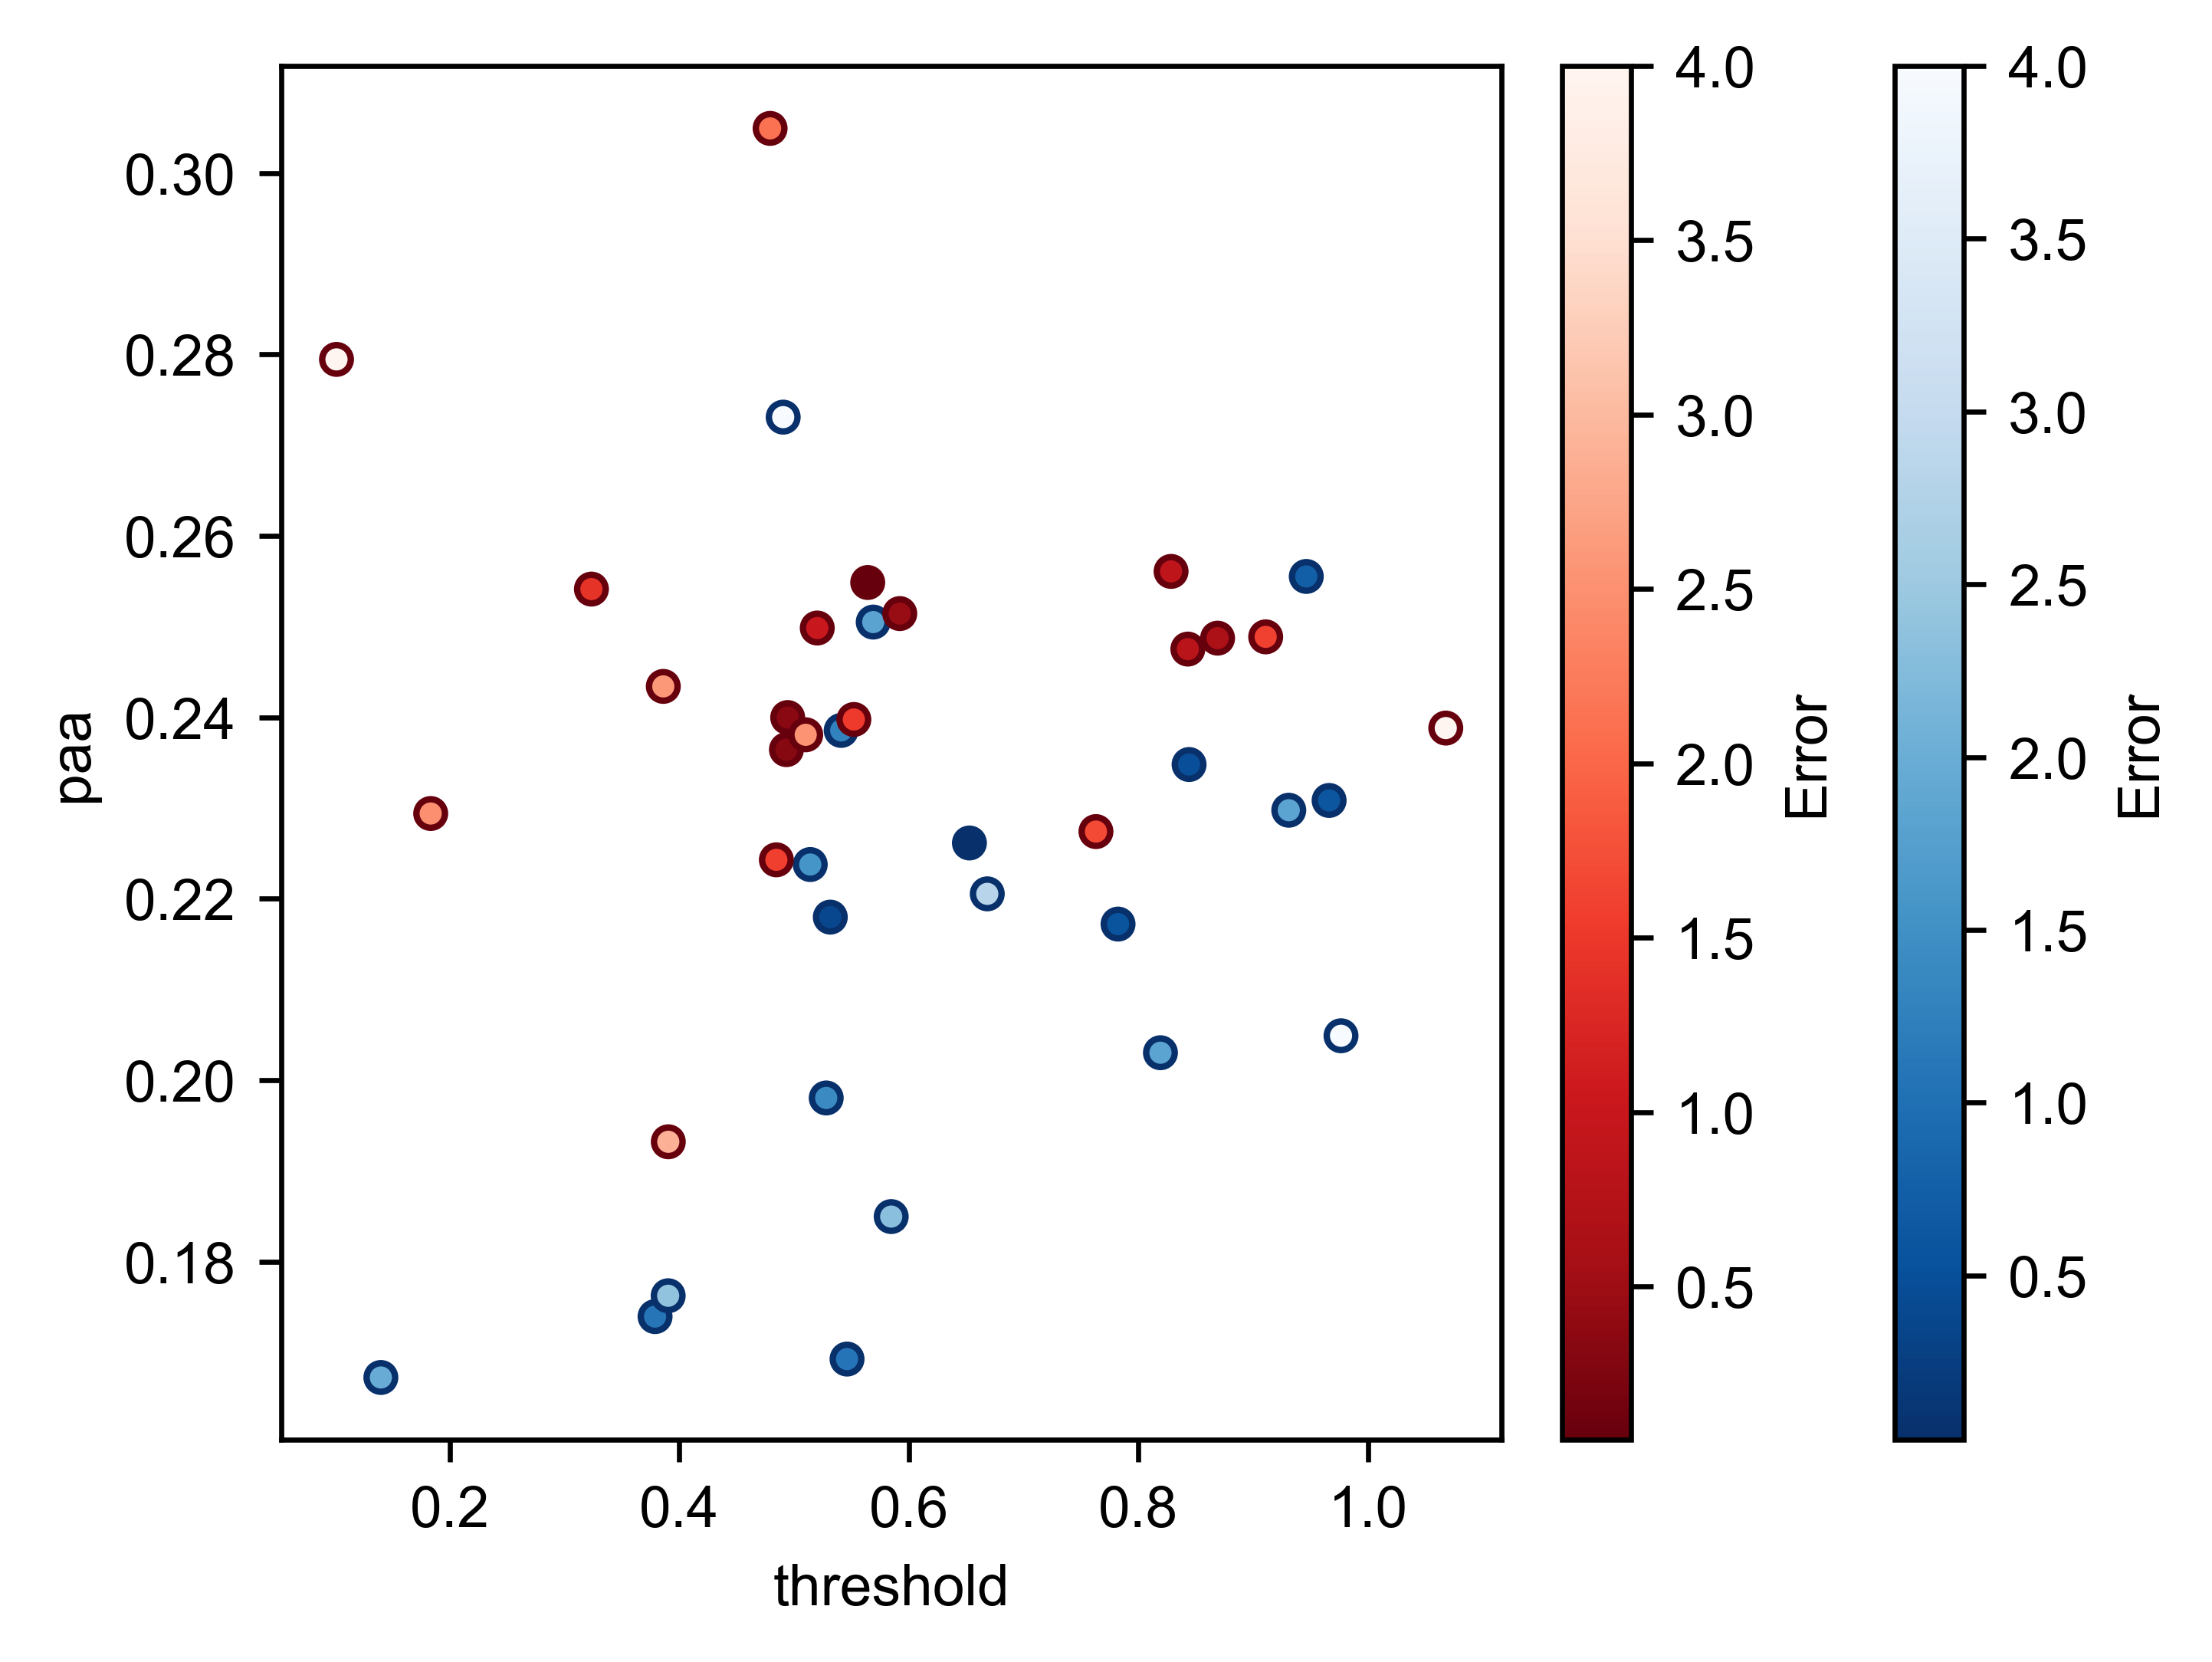

In [12]:
fig, ax = plt.subplots(1, 1)

df.plot.scatter(
    ax=ax,
    x="threshold",
    y="paa",
    c="Error",
    cmap="Blues_r",
    s=20,
    vmax=4,
    edgecolor=plt.get_cmap("Blues")(1.0),
    lw=1.0,
)
df_flopros.plot.scatter(
    ax=ax,
    x="threshold",
    y="paa",
    c="Error",
    cmap="Reds_r",
    s=20,
    vmax=4,
    edgecolor=plt.get_cmap("Reds")(1.0),
    lw=1.0,
)


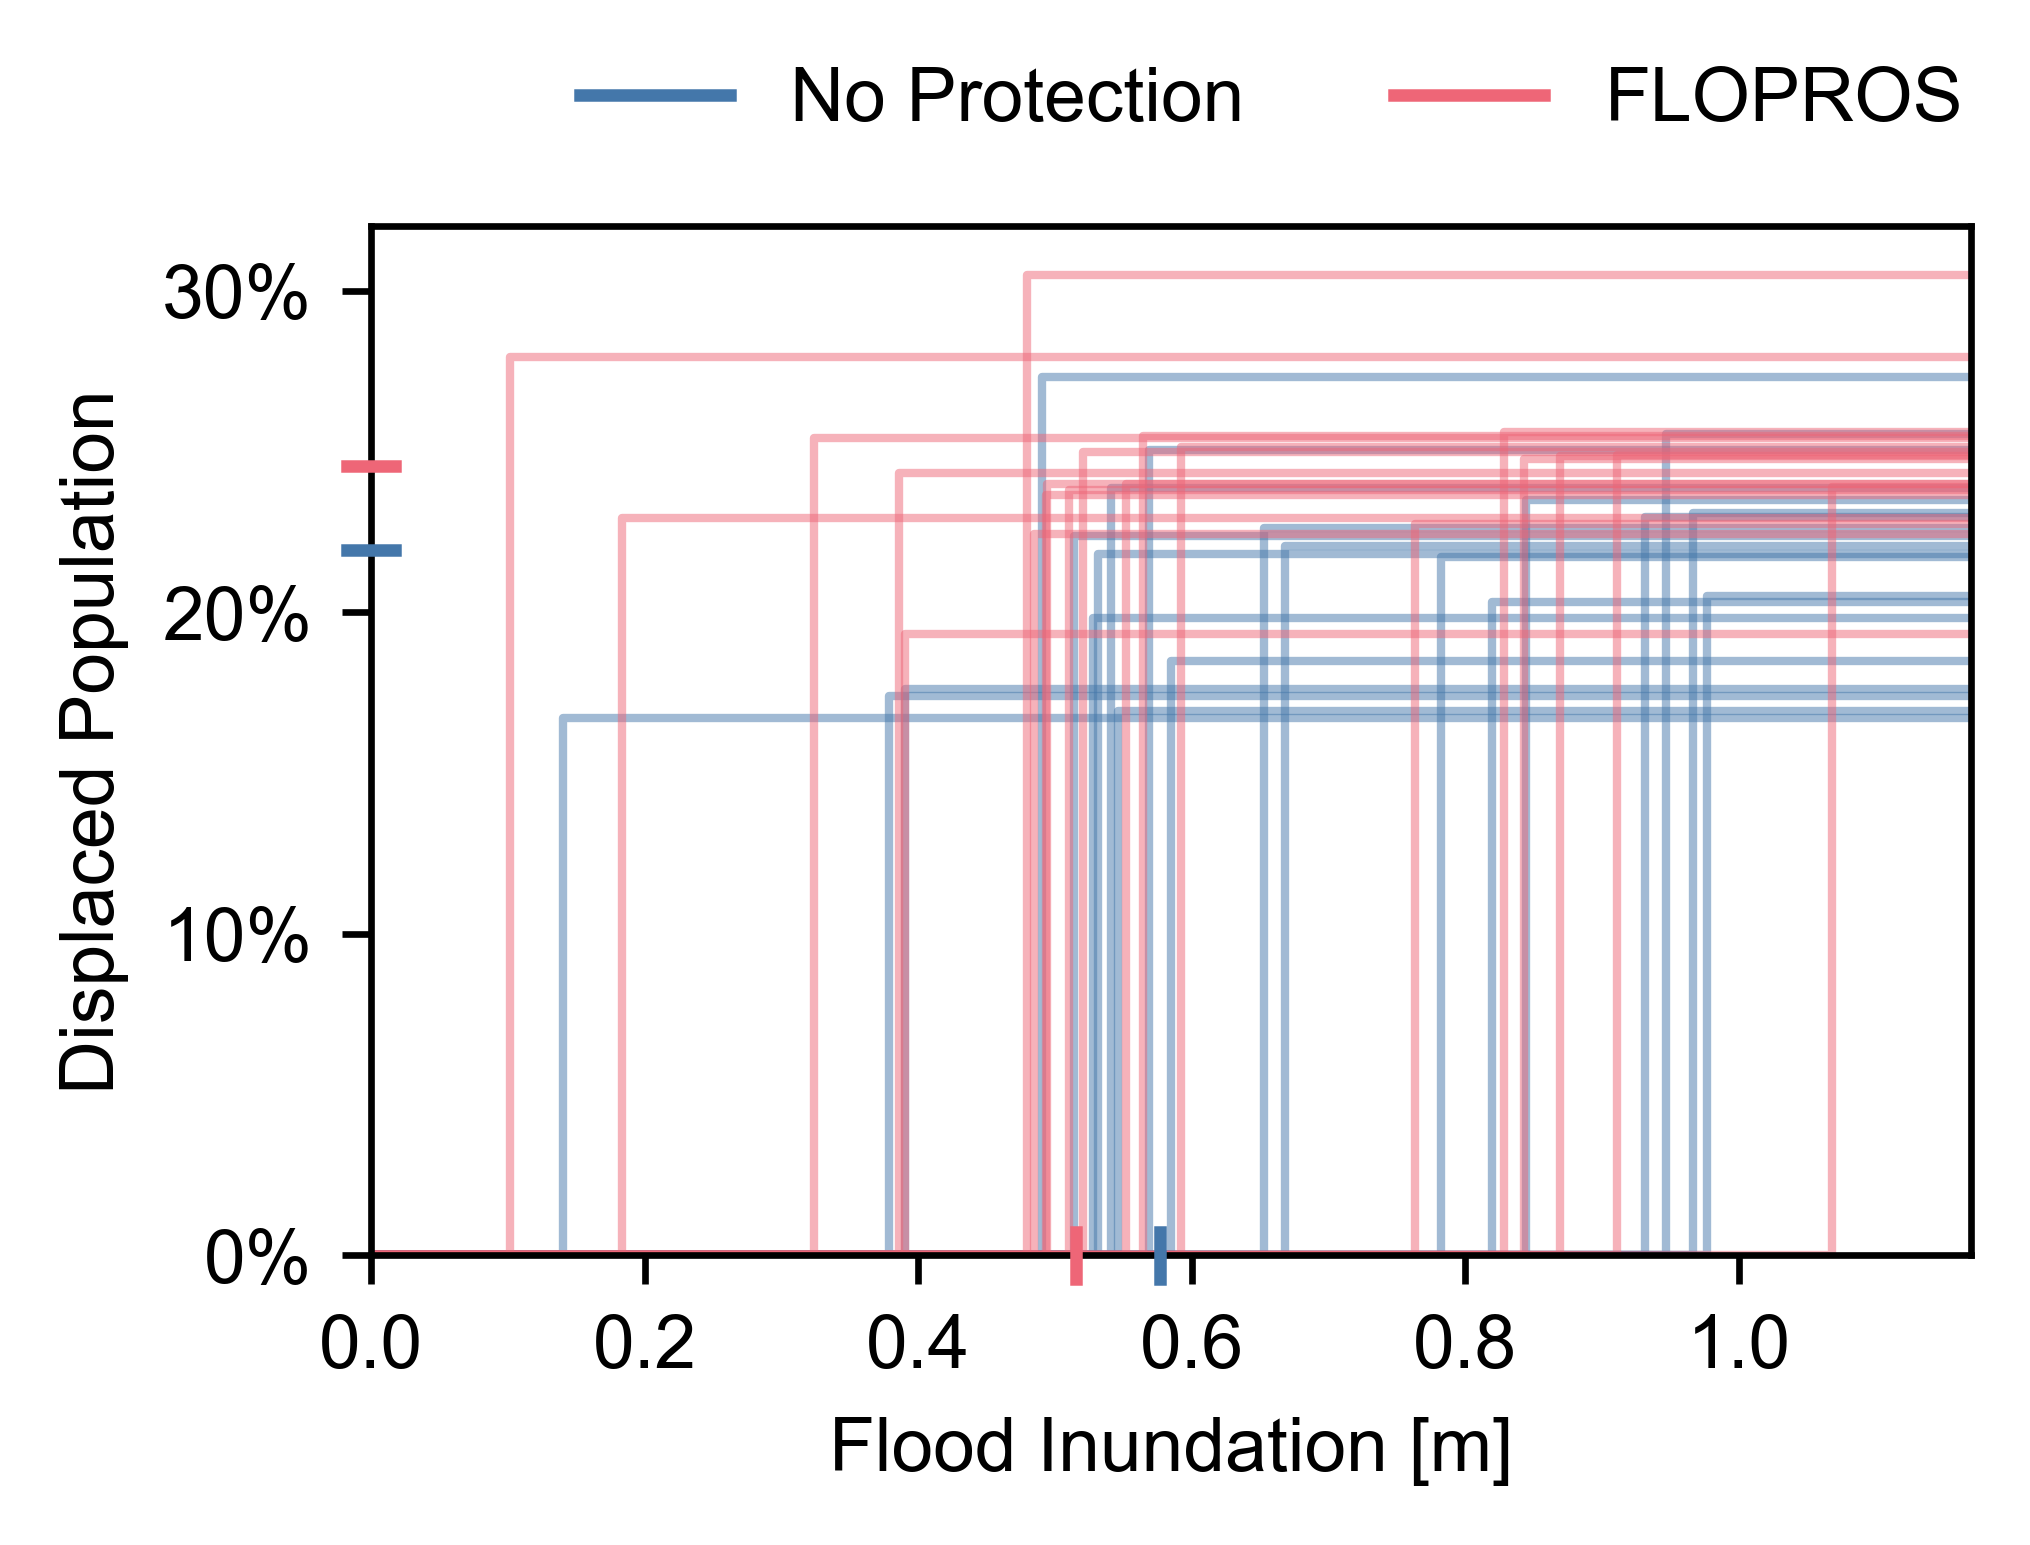

In [23]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDTH_ONE_COL, 0.7 * FIG_HEIGHT))
colors = tol_colors.tol_cset("bright")

X_MAX = 2


def plot_param(threshold, paa, color, **plot_kwargs):
    x = [0, threshold, threshold, X_MAX]
    y = [0, 0, paa, paa]
    ax.plot(x, y, color=color, **plot_kwargs)


alpha = 0.5
for _, param in df.iterrows():
    plot_param(
        threshold=param["threshold"],
        paa=param["paa"],
        color=colors[0],
        lw=1,
        alpha=alpha,
    )
for _, param in df_flopros.iterrows():
    plot_param(
        threshold=param["threshold"],
        paa=param["paa"],
        color=colors[1],
        lw=1,
        alpha=alpha,
    )
# plot_param(
#     threshold=df["threshold"].median(), paa=df["paa"].median(), color=colors[0], label="No Protection"
# )
# plot_param(
#     threshold=df_flopros["threshold"].median(),
#     paa=df_flopros["paa"].median(),
#     color=colors[1],
#     label="FLOPROS"
# )
y_length = 0.023
x_length = 0.015
axvline_kwargs = {"zorder": 3}
l1 = ax.axvline(df["threshold"].median(), ymin=-y_length, ymax=y_length, color=colors[0], **axvline_kwargs)
l2 = ax.axvline(
    df_flopros["threshold"].median(), ymin=-y_length, ymax=y_length, color=colors[1], **axvline_kwargs
)

l3 = ax.axhline(df["paa"].median(), xmin=-x_length, xmax=x_length, color=colors[0], **axvline_kwargs)
l4 = ax.axhline(df_flopros["paa"].median(), xmin=-x_length, xmax=x_length, color=colors[1], **axvline_kwargs)

for l in (l1, l2, l3, l4):
    l.set_clip_on(False)

ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel("Displaced Population")
ax.set_xlabel("Flood Inundation [m]")

df_all = pd.concat([df, df_flopros], ignore_index=True)
thres_min, thres_max = df_all["threshold"].min(), df_all["threshold"].max()
ax.set_xlim(left=0, right=thres_max + thres_min)
ax.set_ylim(bottom=0)

fig.legend(
    handles=[
        mlines.Line2D([], [], color=color, label=label)
        for color, label in zip(colors, ["No Protection", "FLOPROS"])
    ],
    loc="outside upper right",
    ncols=2,
    frameon=False,
)
fig.savefig("impact-functions-cv.pdf")

In [ ]:


df["Protection"] = "No Protection"
df_flopros["Protection"] = "FLOPROS"
data = pd.concat([df, df_flopros], ignore_index=True)
data

paa  threshold  Cost Function      Error     Protection
0   0.229768   0.931045       1.304445   1.815515  No Protection
1   0.173956   0.378989       1.460205   1.092400  No Protection
2   0.230845   0.966181       1.195748   0.607720  No Protection
3   0.217986   0.531640       1.514429   0.366230  No Protection
4   0.169274   0.546225       1.413000   1.069604  No Protection
5   0.203039   0.819253       1.106049   1.815087  No Protection
6   0.226157   0.652844       1.573162   0.023971  No Protection
7   0.234805   0.844199       1.090415   0.482109  No Protection
8   0.220551   0.668396       1.535833   2.819096  No Protection
9   0.223783   0.514174       1.373188   1.575191  No Protection
10  0.255536   0.946291       1.303454   0.748562  No Protection
11  0.250506   0.569037       1.383685   1.802919  No Protection
12  0.198053   0.528078       1.294571   1.415533  No Protection
13  0.273094   0.490599       1.004854  14.481858  No Protection
14  0.176252   0.390402       1.352568   2.374363  No Protection
15  0.167243   0.140119       1.527382   1.971185  No Protection
16  0.217217   0.782316       1.489339   0.568267  No Protection
17  0.204909   0.976555       1.144409   4.126311  No Protection
18  0.238564   0.541123       1.292378   1.270188  No Protection
19  0.184979   0.584692       1.375917   2.320752  No Protection
20  0.227415   0.763069       1.197691   1.703265        FLOPROS
21  0.249851   0.520291       1.331351   1.024553        FLOPROS
22  0.248734   0.869026       1.042208   0.647680        FLOPROS
23  0.236448   0.493425       1.407979   0.314346        FLOPROS
24  0.251442   0.592164       1.374982   0.457630        FLOPROS
25  0.248877   0.910938       1.015751   1.597849        FLOPROS
26  0.254868   0.564247       1.437276   0.060232        FLOPROS
27  0.247529   0.843126       1.081888   0.808004        FLOPROS
28  0.243416   0.386162       1.419530   2.568764        FLOPROS
29  0.254142   0.323544       1.309029   1.420888        FLOPROS
30  0.256091   0.828511       1.166587   0.872717        FLOPROS
31  0.304920   0.479209       1.247086   2.125500        FLOPROS
32  0.224301   0.484653       1.157925   1.572965        FLOPROS
33  0.279460   0.101465       0.898190  14.278737        FLOPROS
34  0.193223   0.390508       1.225169   2.889174        FLOPROS
35  0.229405   0.183527       1.421565   2.482158        FLOPROS
36  0.239984   0.494514       1.385959   0.340510        FLOPROS
37  0.238823   1.067828       1.030246   4.537225        FLOPROS
38  0.239769   0.552168       1.324454   1.536212        FLOPROS
39  0.238082   0.510227       1.261253   2.532232        FLOPROS

/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:1760: UserWarning: The figure layout has changed to tight
  f.tight_layout()


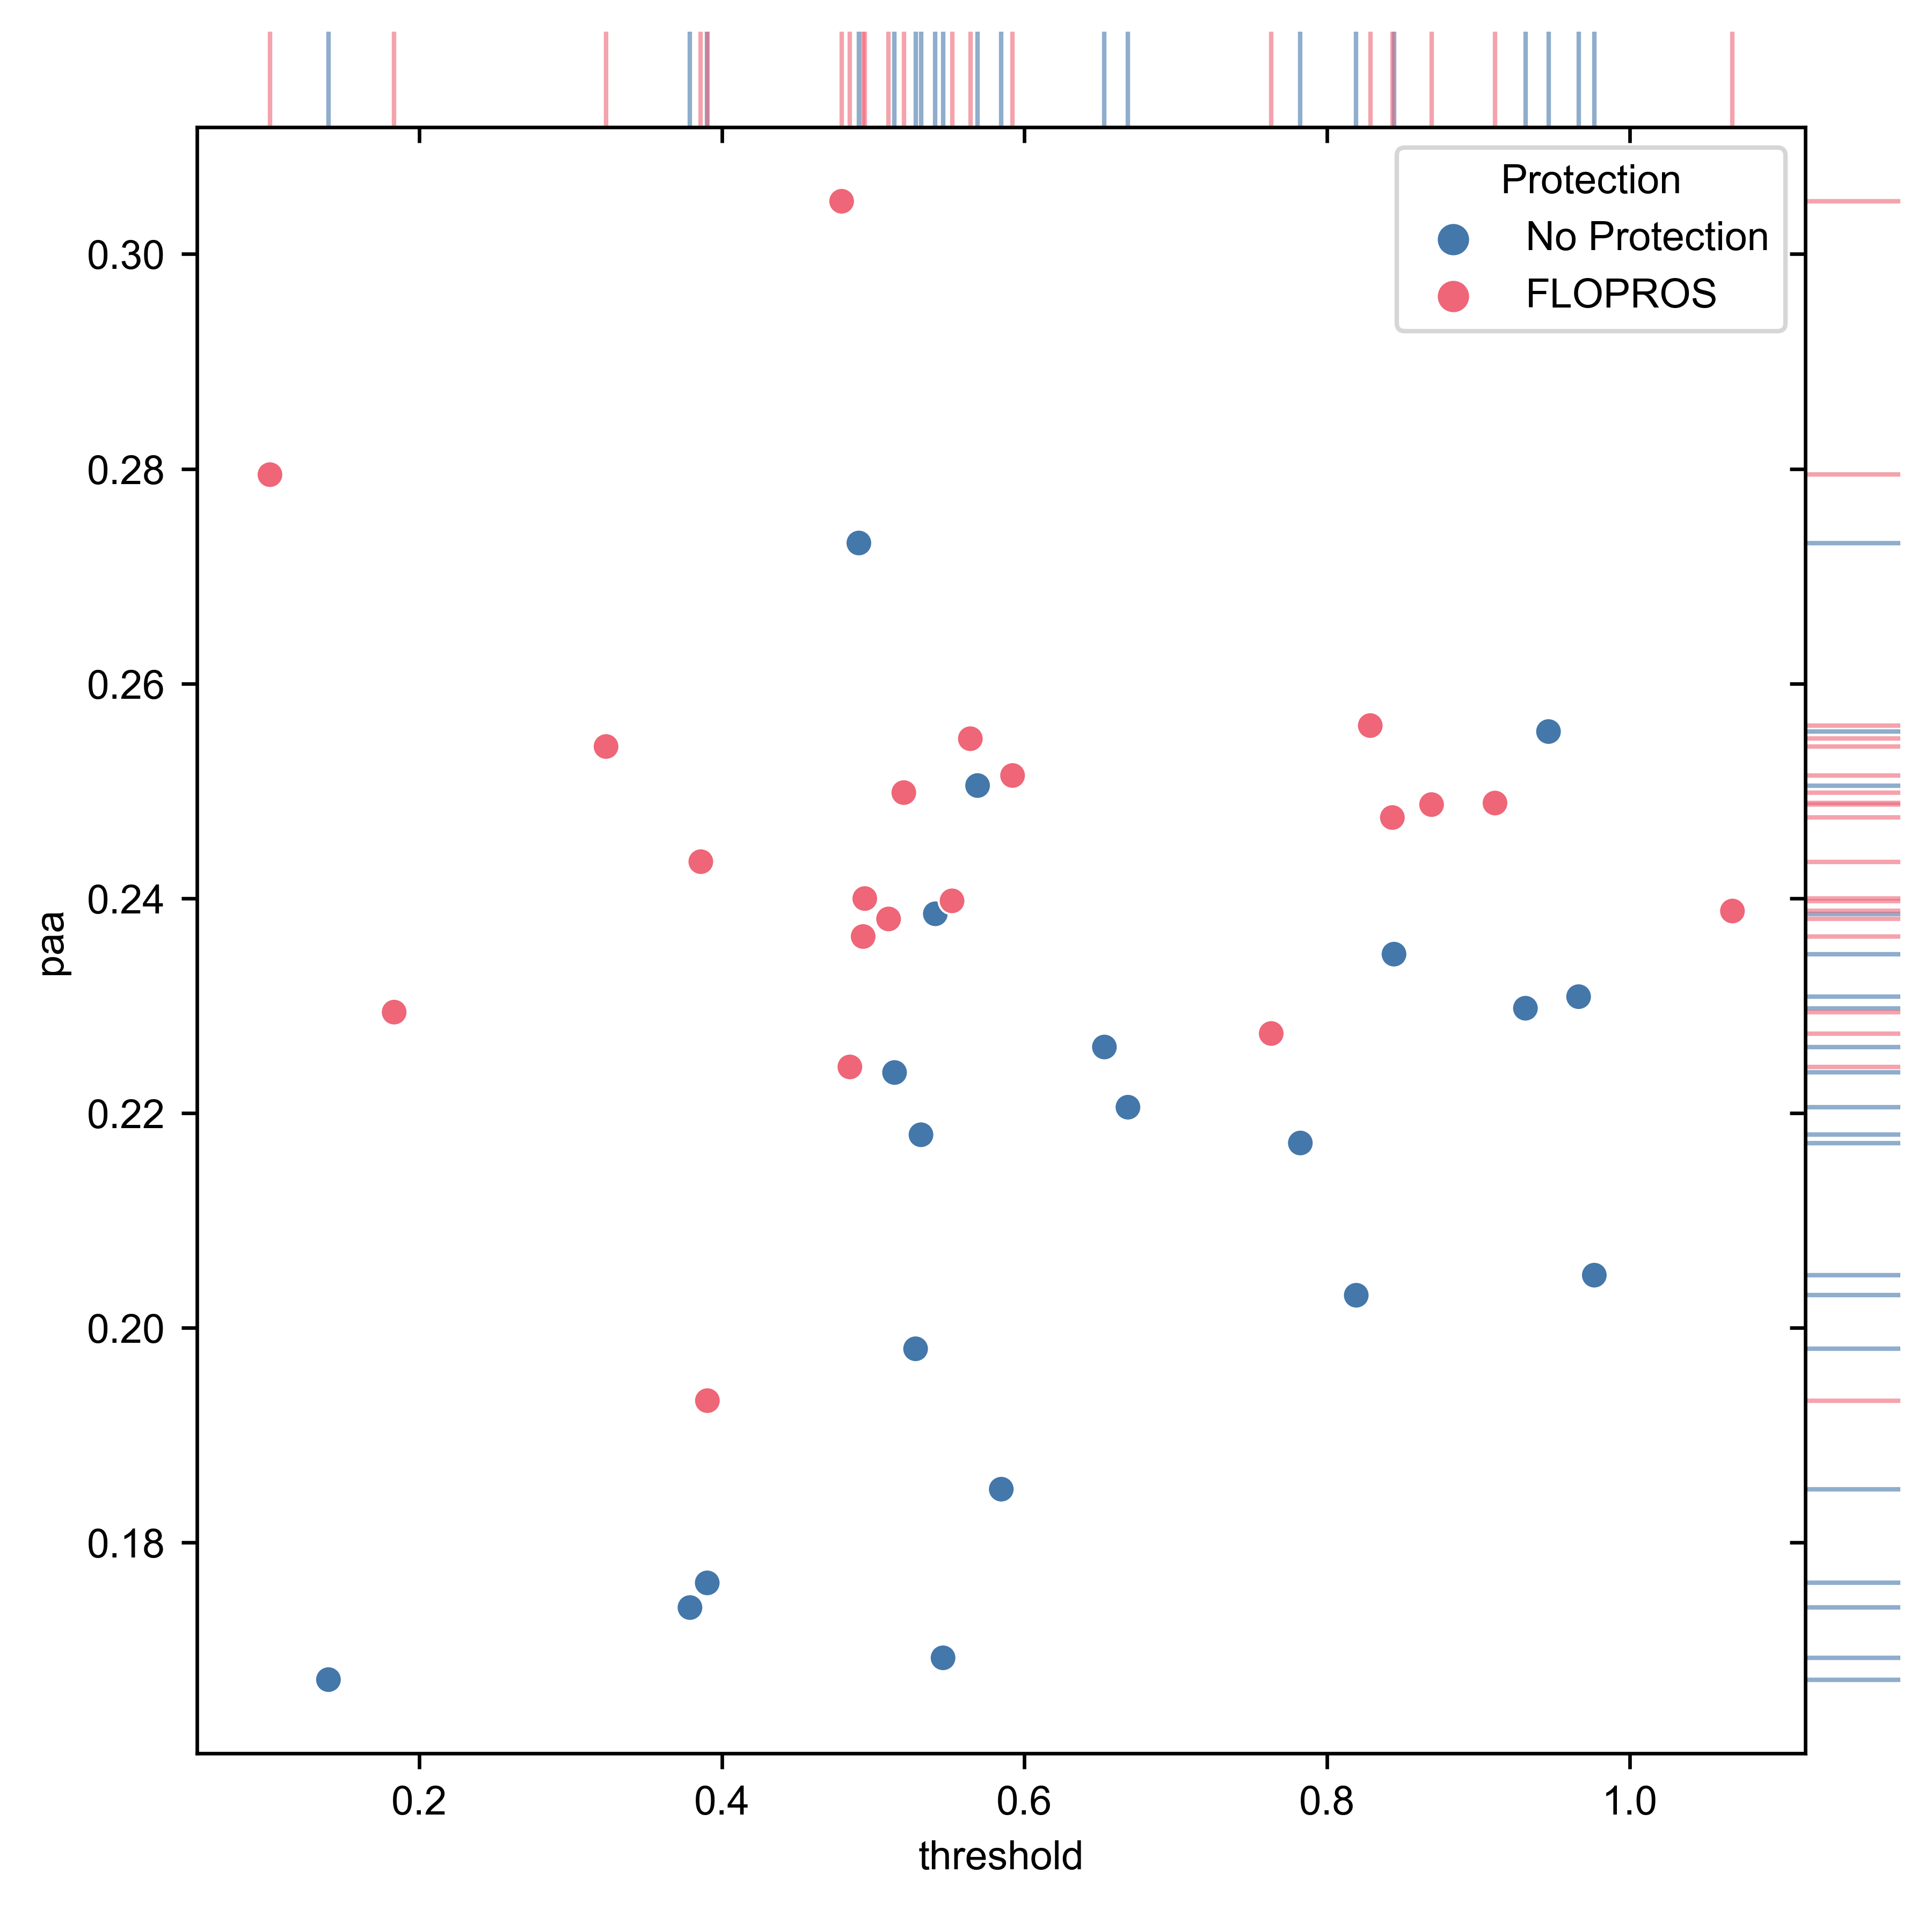

In [ ]:
import seaborn as sns

g = sns.JointGrid(data=data, x="threshold", y="paa", hue="Protection", space=0, ratio=17)
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.rugplot, height=1, alpha=.6)

In [ ]:
from climada.engine import ImpactCalc
from climada.entity import ImpactFunc, ImpactFuncSet

def impf_step_generator(threshold, paa):
    return ImpactFuncSet(
        [
            ImpactFunc.from_step_impf(
                haz_type="RF", intensity=(0, threshold, 100), paa=(0, paa)
            )
        ]
    )


def generate_impact_data(hazard, exposure, calibration_df):
    data = pd.concat(
        [
            ImpactCalc(
                exposure,
                impf_step_generator(threshold=params["threshold"], paa=params["paa"]),
                hazard,
            )
            .impact(save_mat=True)
            .impact_at_reg(exposure.gdf["ADM2_EN"])
            for _, params in calibration_df.iterrows()
        ],
        ignore_index=True,
    )

    # Rename for plotting
    data_plot = data[displacement_data.columns].rename(
        columns={
            "Kambar Shahdad Kot": "QS\u002A",
            "Shaheed Benazir Abad": "SBA\u002A",
            "Tando Muhammad Khan": "TMK\u002A",
            "Naushahro Feroze": "NF\u002A",
            "Umer Kot": "Umerkot",
            # "Tando Allahyar": "TA\u002A",
            # "Mirpur Khas": "Mirpurkhas",
            "Karachi": "Karachi",
        },
        # index={"Data": "Data (PDMA Sindh)"},
    )

    # Add Sum
    data_plot["Sum"] = data_plot.sum(axis=1)

    return data_plot

In [ ]:
from climada_petals.hazard.rf_glofas import hazard_series_from_dataset

# Load NEW hazard footprints
with xr.open_dataset(
    DATA_GEN_DIR / "pakistan-flood-220701-220930.nc", chunks="auto"
) as ds:
    ds["time"] = [np.datetime64("2022-09-30")]
    flood_depth = hazard_series_from_dataset(
        ds, intensity="flood_depth", event_dim="time"
    )[0]
    flood_depth_flopros = hazard_series_from_dataset(
        ds, intensity="flood_depth_flopros", event_dim="time"
    )[0]


/var/folders/fj/w4lbl0pd7l1gcvt664mkfnh00000gq/T/ipykernel_99292/4252666452.py:7: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds["time"] = [np.datetime64("2022-09-30")]
/var/folders/fj/w4lbl0pd7l1gcvt664mkfnh00000gq/T/ipykernel_99292/4252666452.py:7: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the D

In [ ]:
data_plot = generate_impact_data(flood_depth, exposure, df)
data_plot_flopros = generate_impact_data(flood_depth_flopros, exposure, df_flopros)

In [ ]:
data_plot

Khairpur        Larkana           Dadu       Umerkot    Mirpur Khas  \
0   357594.813111  281361.749027  302367.650586  44393.111070  111025.131182   
1   321101.818787  252172.211938  251559.456349  62248.160424  119766.433213   
2   354821.941274  279266.020739  301569.990004  43315.138186  108170.307314   
3   387567.838011  302869.741639  309102.688389  69755.138171  134977.359632   
4   300181.139854  233711.788485  239820.760809  53782.634993  102234.751296   
5   332646.599449  258296.959815  274509.921893  44823.605733  103430.971127   
6   390357.677853  304939.119122  315811.552869  63043.671077  126540.057725   
7   380527.516380  296856.424155  314760.206257  50252.394602  118306.015412   
8   379186.166114  296828.900514  307796.944262  59665.762745  122016.315274   
9   399260.394049  312752.879087  317700.067517  72513.210173  139554.117397   
10  396413.299922  312265.073301  336207.895960  49056.804144  121806.084038   
11  442395.614105  344176.088797  353317.924898  77728.234552  149838.668357   
12  352639.511228  275299.036522  280859.504132  63646.334491  122906.229898   
13  490040.584950  386451.434357  388279.419131  89476.277564  174118.742901   
14  323964.241749  254986.506156  254604.342944  61781.891142  120456.358737   
15  335667.452529  252318.227078  250864.445659  75935.326342  139420.797253   
16  360344.925283  278224.905948  295104.458152  51330.909512  113012.859667   
17  312905.821629  246914.675809  266426.468572  38166.956174   95572.217690   
18  423658.958541  329559.103464  338255.032498  76133.984355  144350.255179   
19  325481.030876  252220.090677  260401.673050  56684.744881  109401.692446   

              QS*           SBA*         Sukkur        Sanghar       Kashmore  \
0   239237.158256  221655.232027  240555.175075  302045.952184  218970.535160   
1   229427.076148  198947.662693  220998.430973  297346.626209  175759.002184   
2   234938.687175  221461.073806  239871.263667  299282.527208  218313.445214   
3   277826.722992  237893.822607  264170.963892  352872.169465  216534.562093   
4   214702.411180  183732.005310  204850.419614  272263.509555  168057.749134   
5   223960.068617  204001.338068  222464.607010  282886.436671  196375.276954   
6   275854.138298  238478.998935  263172.167237  345192.235212  222294.001068   
7   254987.415792  234556.478712  254107.866142  324695.890042  225359.315354   
8   266732.524385  231671.430091  254770.813550  334005.582611  216753.848749   
9   286359.937834  245392.163323  272608.729567  364135.143792  222738.331126   
10  263782.294381  246147.033374  267076.479959  334082.775636  243083.949083   
11  314566.828021  270451.121216  298630.791368  399305.477055  247131.638272   
12  252592.013937  216423.455208  240727.217562  320941.575720  196983.620703   
13  350864.676601  301457.500223  333566.220868  448852.594779  274045.804471   
14  231925.024923  200992.475924  223057.167571  300078.398352  178001.774817   
15  228906.575452  211574.088057  223676.436113  312468.570686  171757.256884   
16  244157.643799  220451.257787  240999.146022  309065.440742  210515.447071   
17  206987.212374  195984.806822  212830.056567  264522.418261  193658.675695   
18  303017.072457  259141.524227  288994.760285  384076.784940  236949.381869   
19  230597.512772  199051.301500  219333.114898  292638.676121  182355.024603   

    ...      Shikarpur         Ghotki        Matiari          Badin  \
0   ...  151205.549975  323628.476845  170851.549151   38620.007117   
1   ...  150293.209778  260228.443328  137797.867114   83146.827250   
2   ...  149464.992661  322798.899239  171343.800140   35245.357287   
3   ...  172913.211664  321213.079505  170253.376154   78604.904308   
4   ...  133695.923130  249142.361712  132080.410303   59676.334719   
5   ...  142771.944962  290658.434247  153671.205841   42896.738235   
6   ...  170770.249445  330810.089426  174169.060557   65177.697957   
7   ...  162811.490313  334934.262869  177187.560347   470

In [ ]:
data_plot.columns.tolist()

['Khairpur',
 'Larkana',
 'Dadu',
 'Umerkot',
 'Mirpur Khas',
 'QS*',
 'SBA*',
 'Sukkur',
 'Sanghar',
 'Kashmore',
 'Jamshoro',
 'Jacobabad',
 'NF*',
 'Sujawal',
 'Thatta',
 'Shikarpur',
 'Ghotki',
 'Matiari',
 'Badin',
 'Tando Allahyar',
 'Hyderabad',
 'Tharparkar',
 'TMK*',
 'Karachi',
 'Sum']

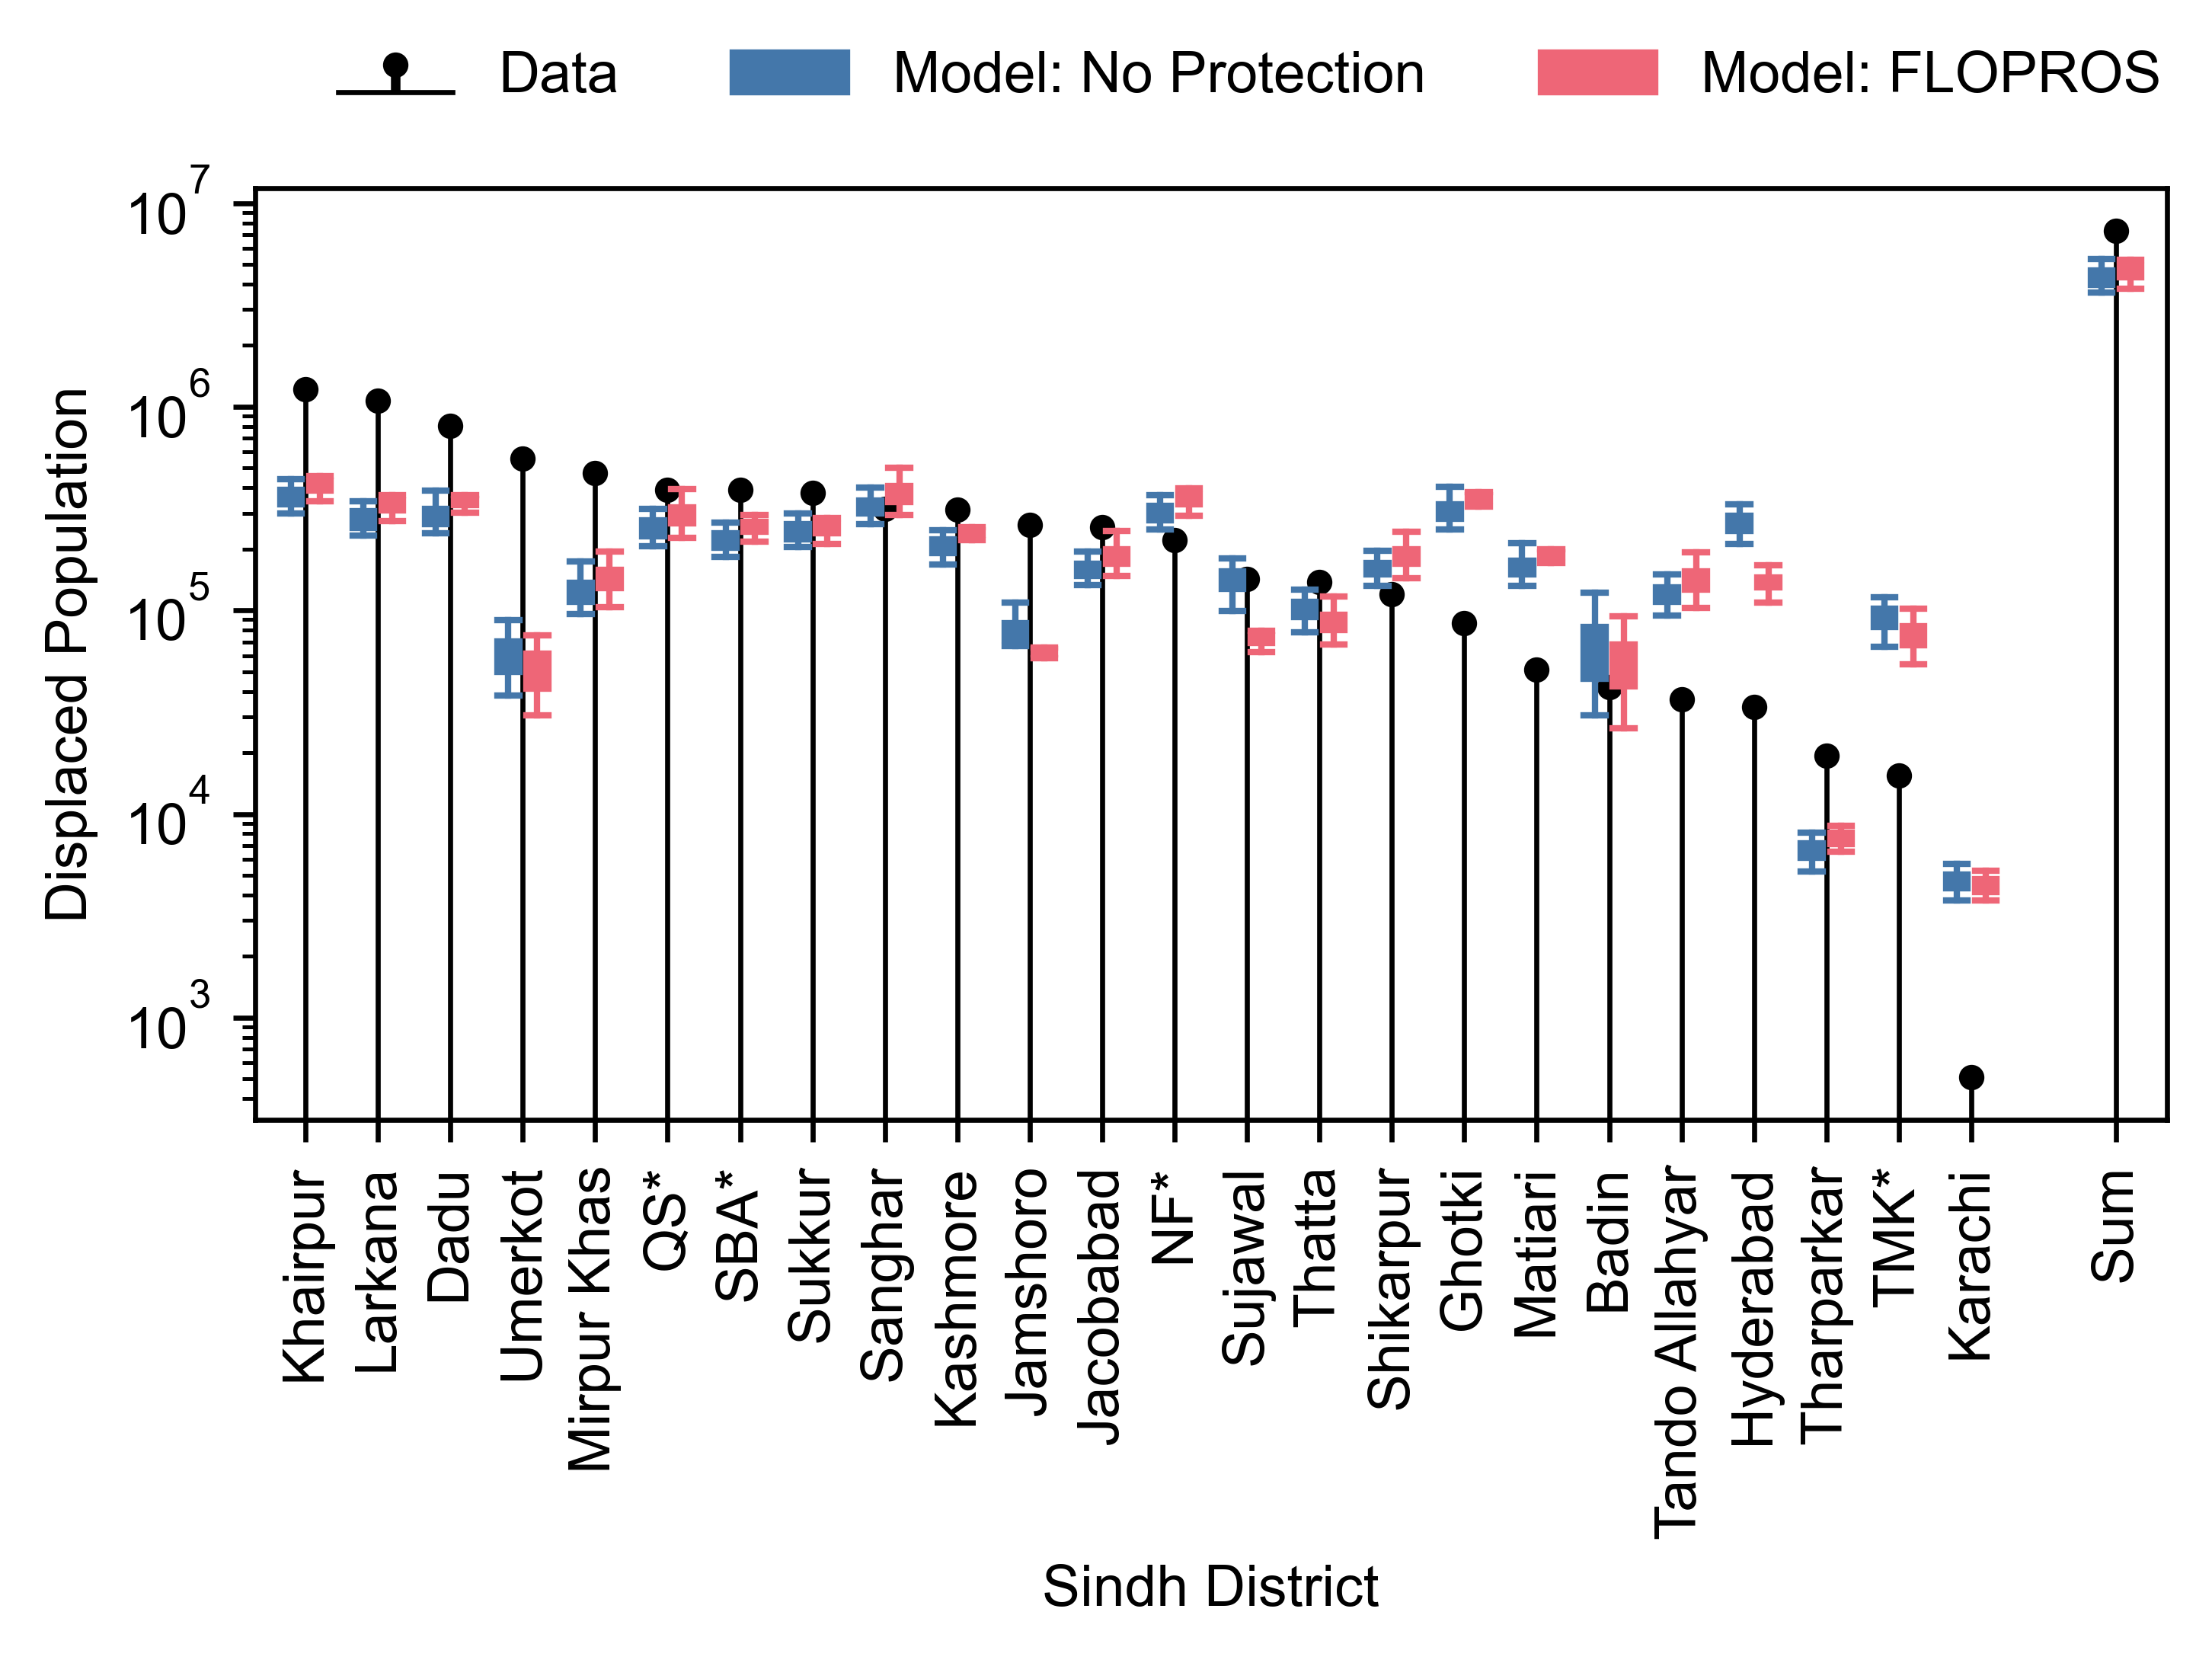

In [ ]:
fig, ax = plt.subplots(1, 1)
colors = tol_colors.tol_cset("bright")

for idx, (arr, color) in enumerate(zip((data_plot, data_plot_flopros), colors)):
    arr = arr.to_numpy()

    # Set positions
    positions=np.array(list(range(arr.shape[1])))
    positions[-1] = positions[-1] + 1  # Extend last one (the sum)
    positions = positions - 0.2 + 0.4 * idx  # Shift

    ax.boxplot(
        arr,
        showfliers=False,
        positions=positions,
        widths=0.3,
        capwidths=0.3,
        patch_artist=True,
        medianprops=dict(alpha=0),
        boxprops=dict(color=color, facecolor=color),
        capprops=dict(color=color),
        whiskerprops=dict(color=color),
        zorder=5,
    )
ax.set_xticks([])

markerline, stemlines, baseline = ax.stem(
    range(len(displacement_data.columns)),
    displacement_data.iloc[0],
    linefmt="k",
    markerfmt="k",
    basefmt="k",
)
markerline.set_markersize(3)
stemlines.set_linewidth(plt.rcParams["xtick.major.width"])

markerline, stemlines, baseline = ax.stem(
    len(displacement_data.columns) + 1,
    displacement_data.sum(axis=1),
    linefmt="k",
    markerfmt="k",
    basefmt="k",
    label="Data",
)
markerline.set_markersize(3)
stemlines.set_linewidth(plt.rcParams["xtick.major.width"])

ax.set_yscale("log")
ax.set_xticks(list(range(len(data_plot.columns) - 1)) + [len(data_plot.columns)])
ax.set_xticklabels(data_plot.columns.tolist(), rotation="vertical")

ax.set_ylabel("Displaced Population")
ax.set_xlabel("Sindh District")

h, l = ax.get_legend_handles_labels()
h[0].markerline.set_markersize(3)
h[0].stemlines.set_linewidth(plt.rcParams["xtick.major.width"])
h[0].baseline.set_linewidth(plt.rcParams["xtick.major.width"])

h.append(mpatches.Patch(color=colors[0], label="Model: No Protection"))
h.append(mpatches.Patch(color=colors[1], label="Model: FLOPROS"))

fig.legend(handles=h, loc="outside upper right", frameon=False, ncols=3)
fig.savefig("sindh-impact-cv.pdf")